In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import re

from functools import partial
import scipy as sp
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
train = pd.read_csv('//Users/sangeetadutta/Downloads/Kaggle/train.csv')
test = pd.read_csv('//Users/sangeetadutta/Downloads/Kaggle/test.csv')

In [3]:
train.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,None,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


Text(0, 0.5, 'Frequency')

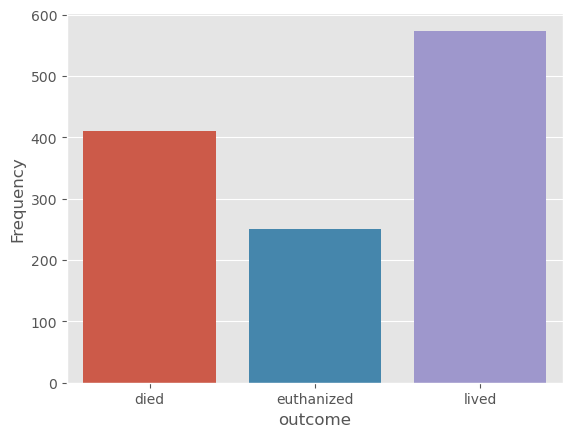

In [4]:
sns.countplot(data=train,x='outcome')
plt.ylabel('Frequency')

<Axes: xlabel='outcome', ylabel='peripheral_pulse'>

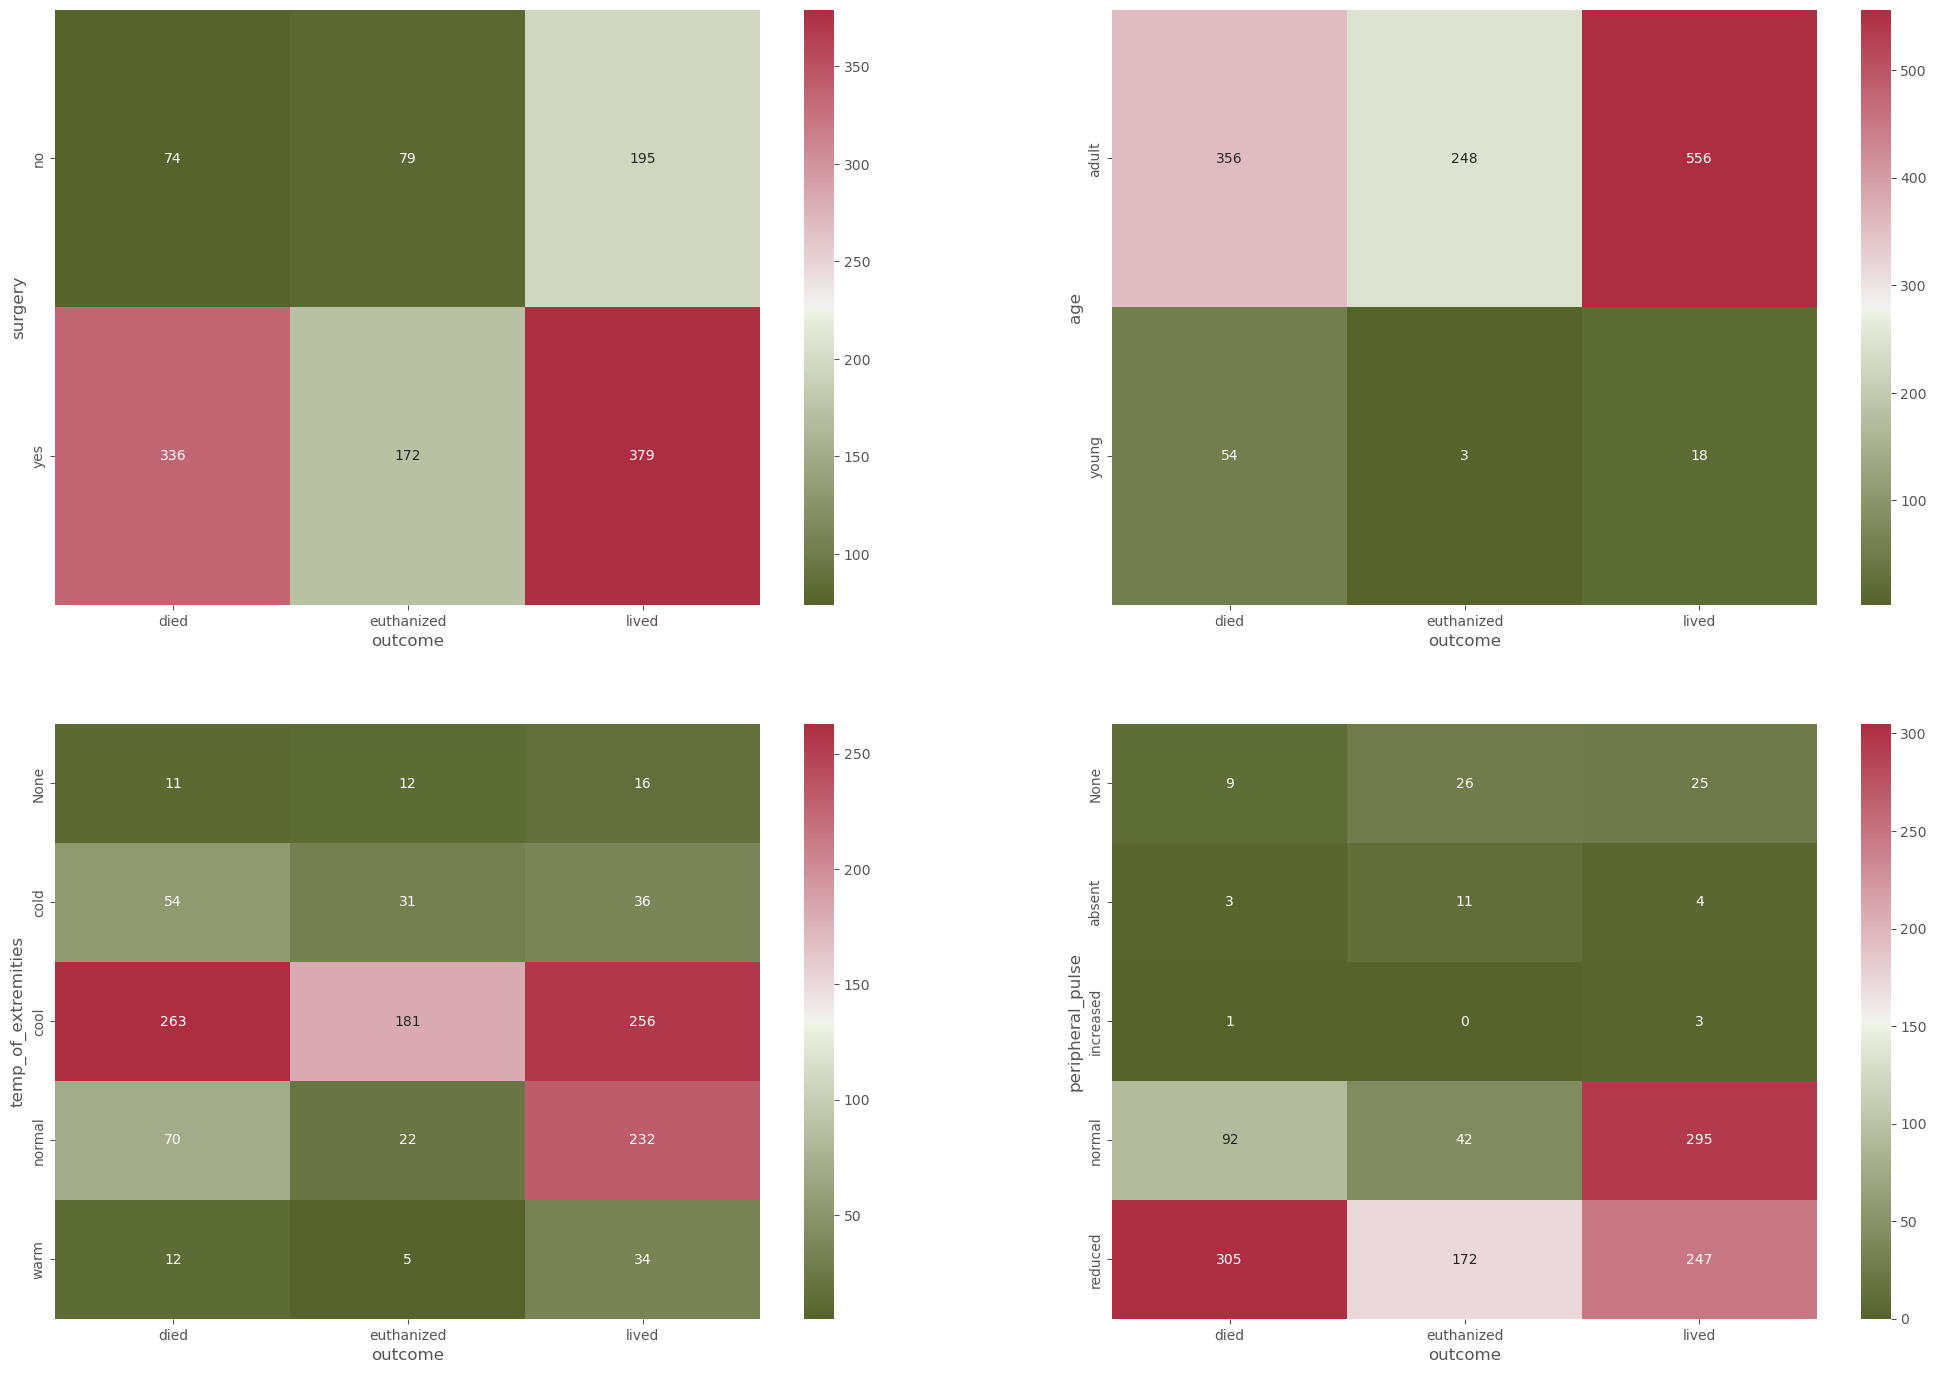

In [5]:
fig, axes = plt.subplots(2, 2, figsize = (25, 17))
cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)
sns.heatmap(data = pd.crosstab(train['surgery'], train['outcome']), annot = True, cmap = cmap, fmt = '.0f', ax = axes[0, 0])
sns.heatmap(data = pd.crosstab(train['age'], train['outcome']), annot = True, cmap = cmap, fmt = '.0f', ax = axes[0, 1])
sns.heatmap(data = pd.crosstab(train['temp_of_extremities'], train['outcome']), annot = True, cmap = cmap, fmt = '.0f', ax = axes[1, 0])
sns.heatmap(data = pd.crosstab(train['peripheral_pulse'], train['outcome']), annot = True, cmap = cmap, fmt = '.0f', ax = axes[1, 1])

<Axes: xlabel='outcome', ylabel='nasogastric_reflux_ph'>

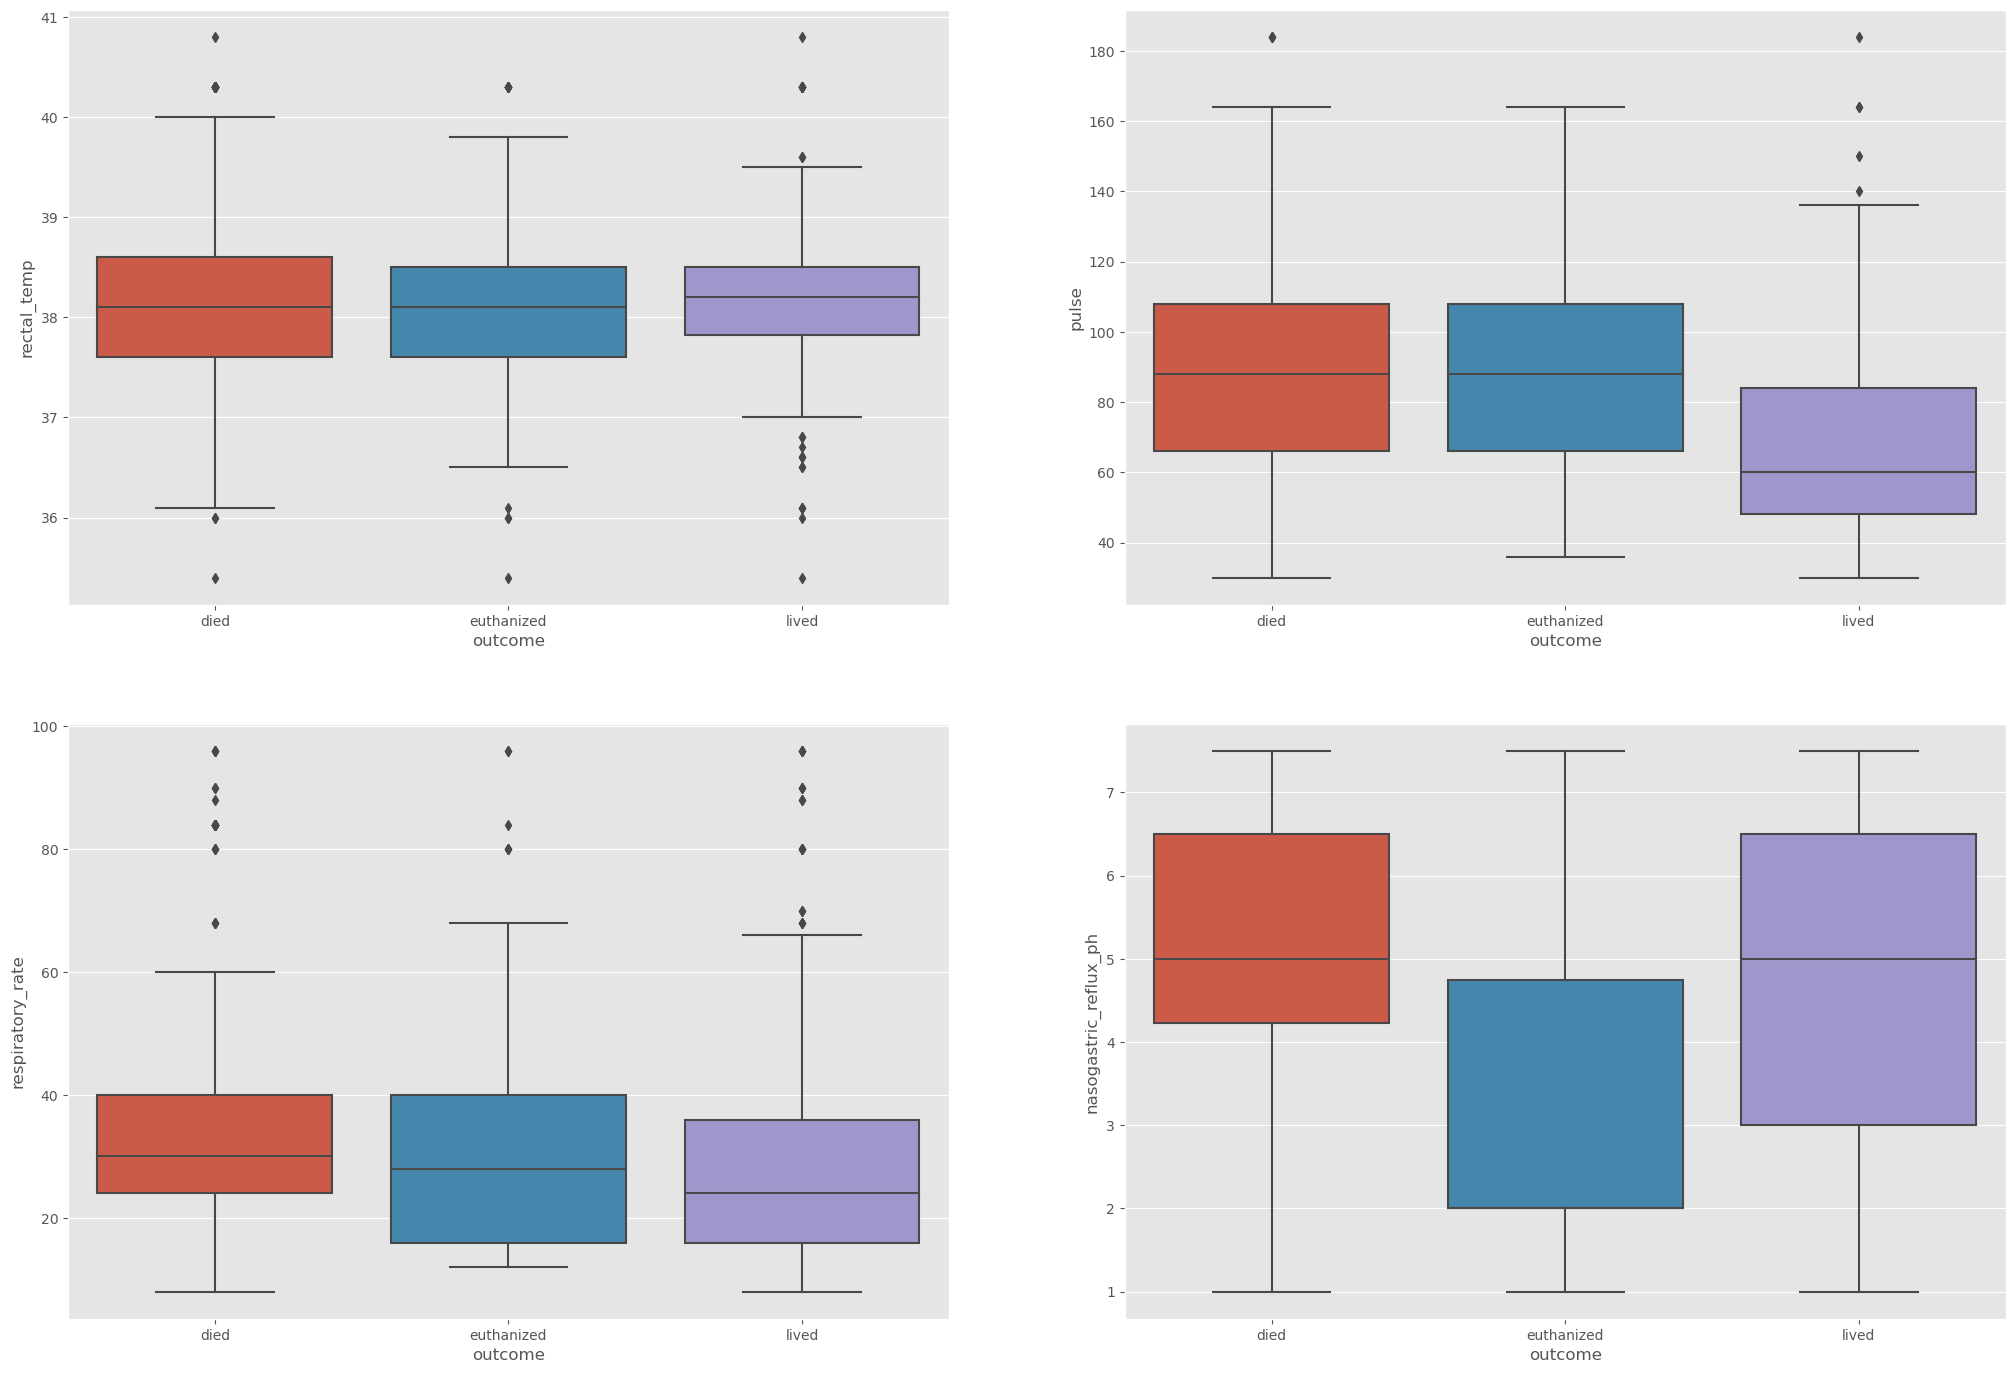

In [6]:
fig, axes = plt.subplots(2, 2, figsize = (25, 17))

sns.boxplot(ax = axes[0, 0], data = train, x = 'outcome', y = 'rectal_temp')
sns.boxplot(ax = axes[0, 1], data = train, x = 'outcome', y = 'pulse')
sns.boxplot(ax = axes[1, 0], data = train, x = 'outcome', y = 'respiratory_rate')
sns.boxplot(ax = axes[1, 1], data = train, x = 'outcome', y = 'nasogastric_reflux_ph')

<Axes: xlabel='outcome', ylabel='lesion_1'>

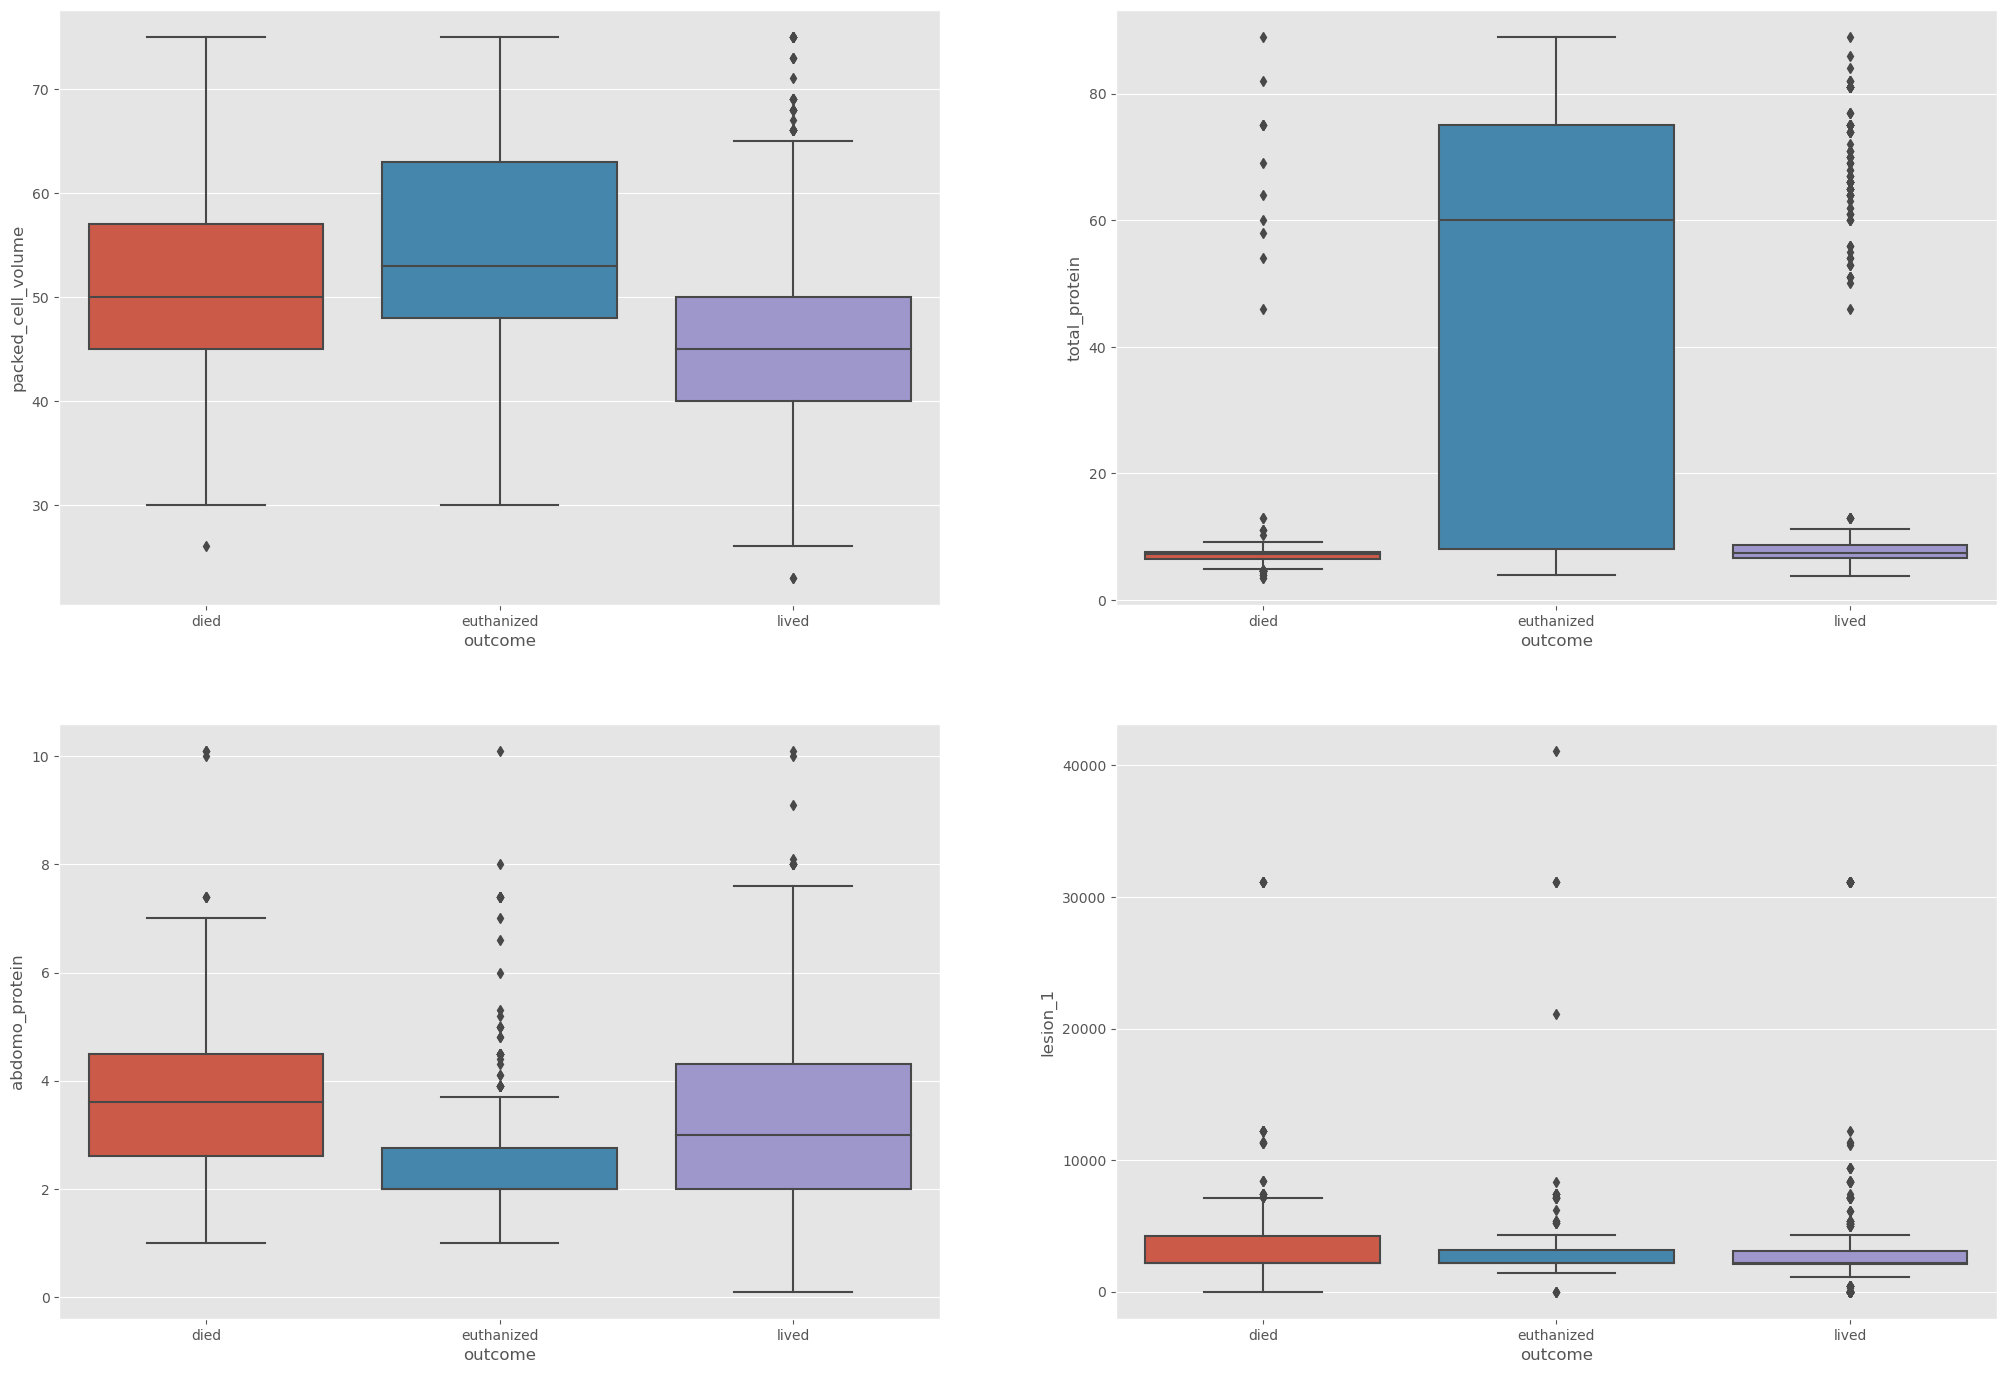

In [7]:
fig, axes = plt.subplots(2, 2, figsize = (25, 17))

sns.boxplot(ax = axes[0, 0], data = train, x = 'outcome', y = 'packed_cell_volume')
sns.boxplot(ax = axes[0, 1], data = train, x = 'outcome', y = 'total_protein')
sns.boxplot(ax = axes[1, 0], data = train, x = 'outcome', y = 'abdomo_protein')
sns.boxplot(ax = axes[1, 1], data = train, x = 'outcome', y = 'lesion_1')

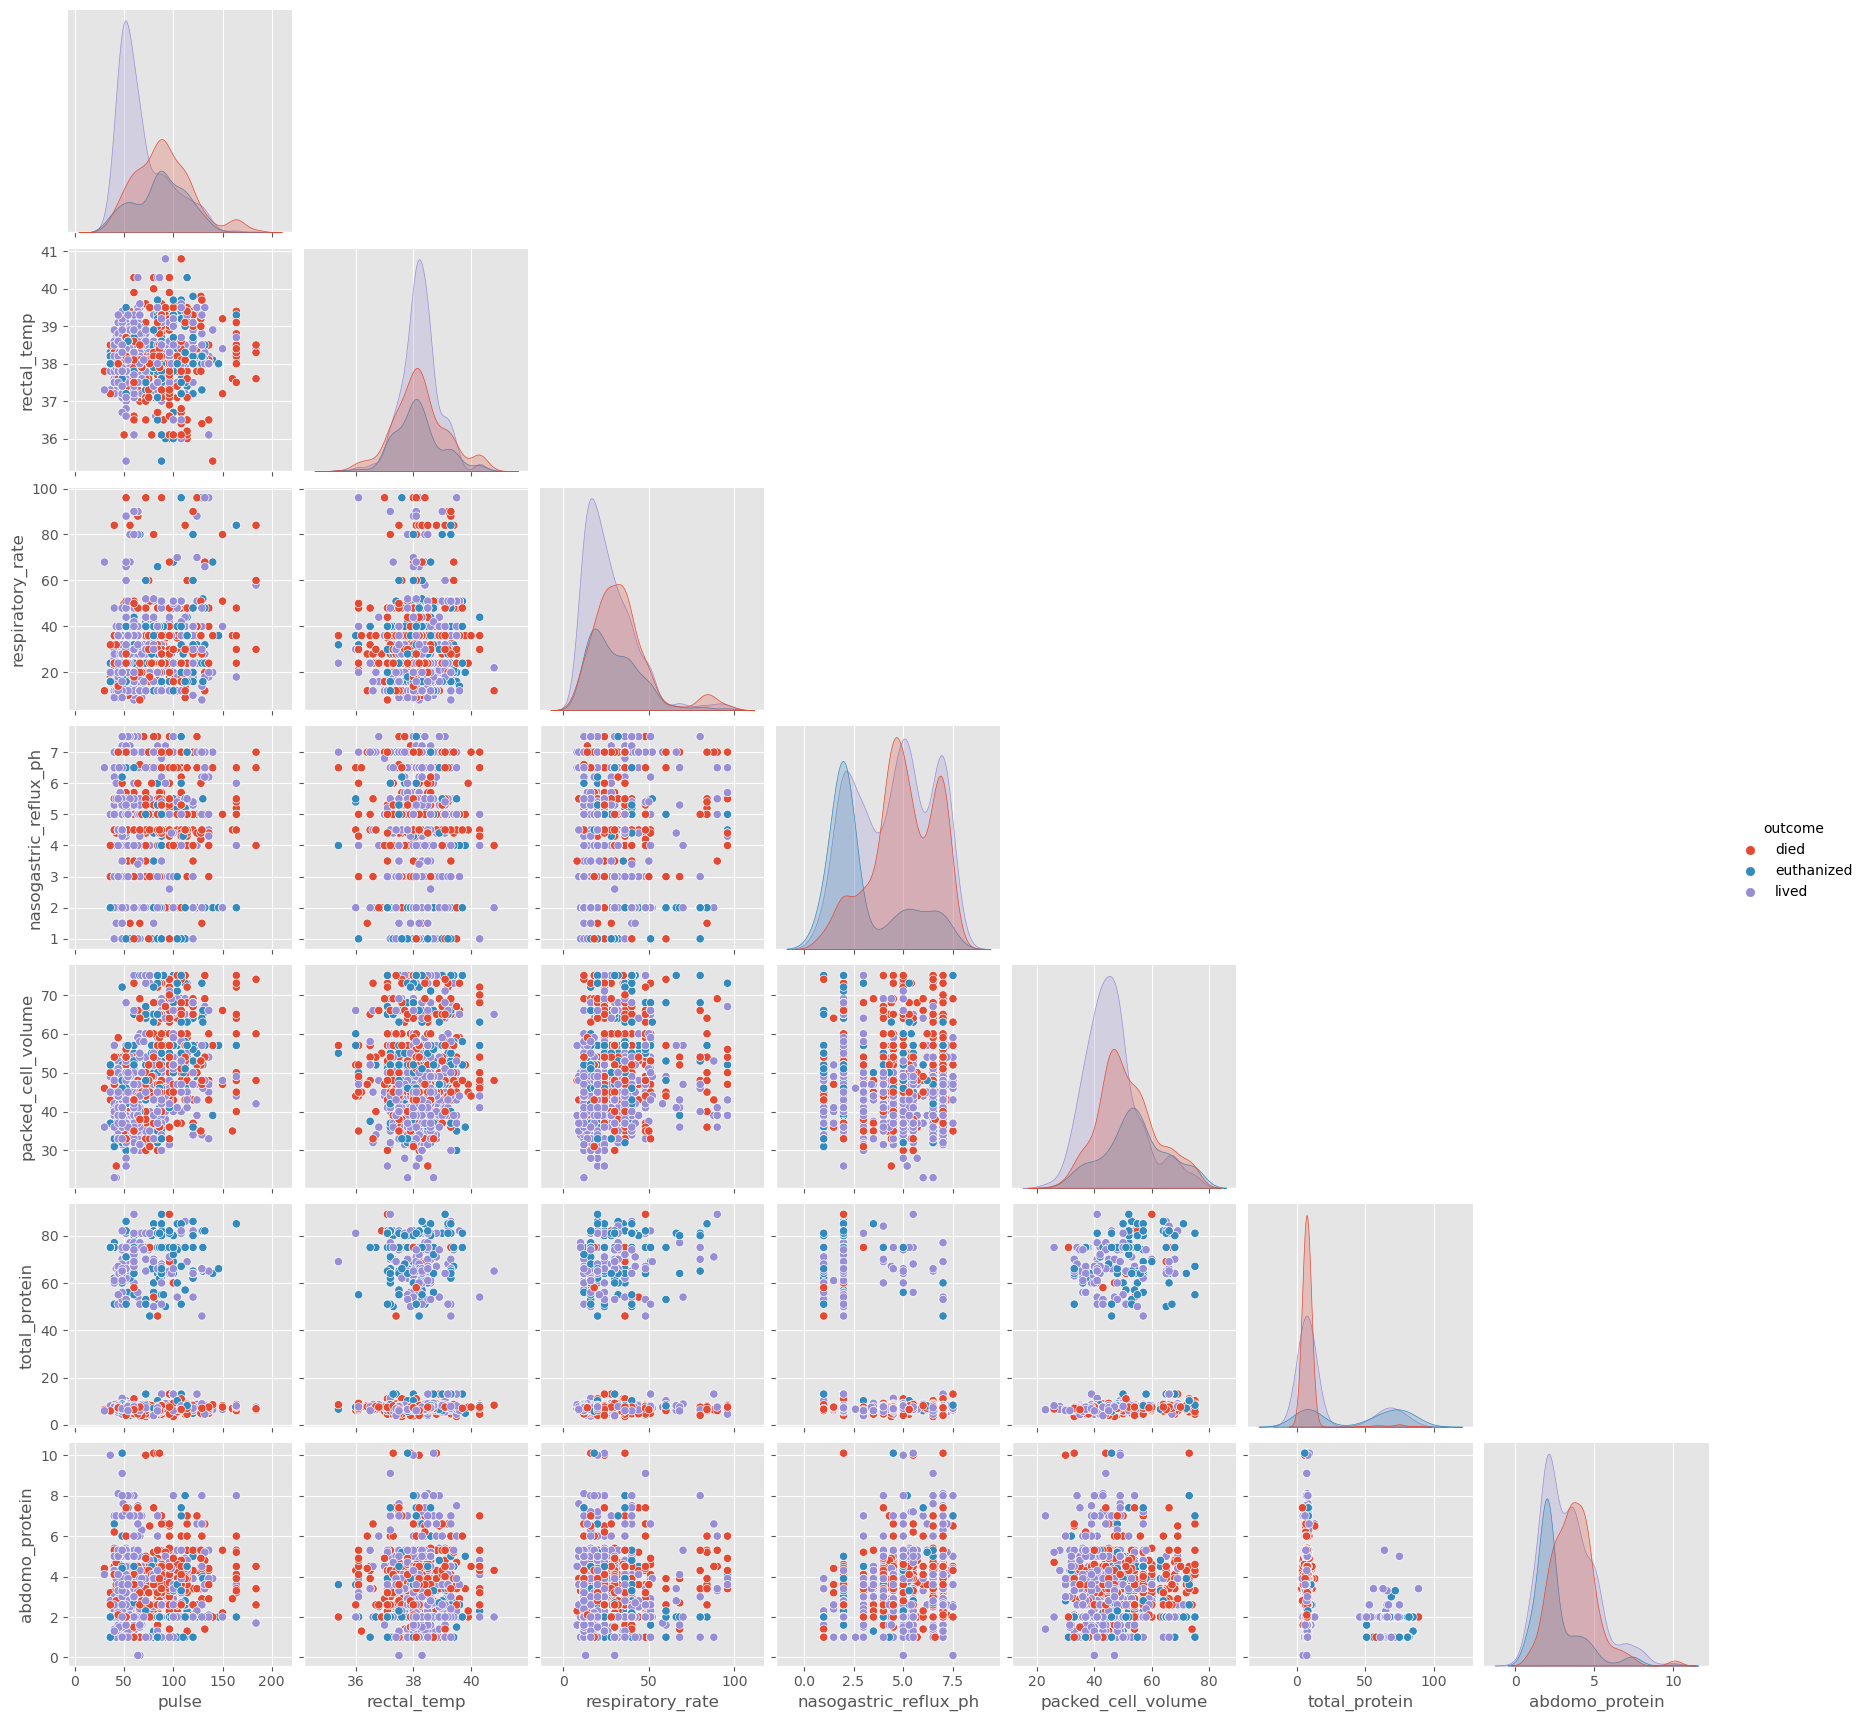

In [8]:
sns.pairplot(data = train[
    ['pulse',
     'rectal_temp',
     'respiratory_rate',
     'nasogastric_reflux_ph',
     'packed_cell_volume',
     'total_protein',
     'abdomo_protein',
     'outcome']],
    hue = 'outcome', corner = True); 

In [10]:
# Baseline Model:
X = pd.concat([pd.get_dummies(train[['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'abdominal_distention', 'abdomo_appearance', 'surgical_lesion']]), 
               train[['pulse', 'respiratory_rate', 'total_protein', 'nasogastric_reflux_ph']]], axis = 1)

Y = train['outcome']
Y = Y.map({'died': 0, 'euthanized': 1, 'lived': 2})

test_cv = pd.concat([pd.get_dummies(test[['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'abdominal_distention', 'abdomo_appearance', 'surgical_lesion']]), 
                     test[['pulse', 'respiratory_rate', 'total_protein', 'nasogastric_reflux_ph']]], axis = 1)

In [11]:
ens = list()

sk = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
for i, (train_idx, test_idx) in enumerate(sk.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    print('----------------------------------------------------------')
    
    ###################
    ## Random Forest ##
    ###################
    
    RF_md = RandomForestClassifier(n_estimators = 500, 
                                   max_depth = 7,
                                   min_samples_split = 15,
                                   min_samples_leaf = 10).fit(X_train, Y_train)

    RF_pred = RF_md.predict(X_test)
    RF_pred_test = RF_md.predict(test_cv)
    RF_score = f1_score(Y_test, RF_pred, average = 'micro')

    print('Fold', i, '==> RF oof F1 score is ==>', RF_score)

    #################
    ## Extra Trees ##
    #################

    ET_md = ExtraTreesClassifier(n_estimators = 500, 
                                 max_depth = 7,
                                 min_samples_split = 15,
                                 min_samples_leaf = 10).fit(X_train, Y_train)

    ET_pred = ET_md.predict(X_test)
    ET_pred_test = ET_md.predict(test_cv)
    ET_score = f1_score(Y_test, ET_pred, average = 'micro')

    print('Fold', i, '==> ET oof F1 score is ==>', ET_score)

    ######################
    ## GradientBoosting ##
    ######################

    GB_md = GradientBoostingClassifier(n_estimators = 500, 
                                       learning_rate = 0.01,
                                       max_depth = 7,
                                       min_samples_split = 15,
                                       min_samples_leaf = 10).fit(X_train, Y_train)

    GB_pred = GB_md.predict(X_test)
    GB_pred_test = GB_md.predict(test_cv)
    GB_score = f1_score(Y_test, GB_pred, average = 'micro')

    print('Fold', i, '==> GB oof F1 score is ==>', GB_score)

    ##########
    ## LGBM ##
    ##########

    LGBM_md = LGBMClassifier(objective = 'multiclass',
                             n_estimators = 500,
                             max_depth = 7,
                             learning_rate = 0.01,
                             num_leaves = 20,
                             reg_alpha = 3,
                             reg_lambda = 3,
                             subsample = 0.7,
                             colsample_bytree = 0.7).fit(X_train, Y_train)

    lgb_pred = LGBM_md.predict(X_test)
    lgb_pred_test = LGBM_md.predict(test_cv)
    lgb_score = f1_score(Y_test, lgb_pred, average = 'micro')

    print('Fold', i, '==> LGBM oof F1 score is ==>', lgb_score)  

    #########
    ## XGB ##
    #########

    XGB_md = XGBClassifier(objective = 'multi:softprob',
                           tree_method = 'hist',
                           colsample_bytree = 0.7, 
                           gamma = 2, 
                           learning_rate = 0.01, 
                           max_depth = 7, 
                           min_child_weight = 10, 
                           n_estimators = 500, 
                           subsample = 0.7).fit(X_train, Y_train)

    xgb_pred = XGB_md.predict(X_test)
    xgb_pred_test = XGB_md.predict(test_cv)
    xgb_score = f1_score(Y_test, xgb_pred, average = 'micro')

    print('Fold', i, '==> XGB oof F1 score is ==>', xgb_score)

    ##############
    ## CatBoost ##
    ##############

    Cat_md = CatBoostClassifier(loss_function = 'MultiClass',
                                iterations = 500,
                                learning_rate = 0.01,
                                depth = 7,
                                random_strength = 0.5,
                                bagging_temperature = 0.7,
                                border_count = 30,
                                l2_leaf_reg = 5,
                                verbose = False, 
                                task_type = 'CPU').fit(X_train, Y_train)

    cat_pred = Cat_md.predict(X_test)
    cat_pred_test = Cat_md.predict(test_cv)
    cat_score = f1_score(Y_test, cat_pred, average = 'micro')

    print('Fold', i, '==> CatBoost oof F1 score is ==>', cat_score)

    ###################
    ## Mode Ensemble ##
    ###################

    md_preds = pd.concat([pd.Series(RF_pred.flatten()), 
                          pd.Series(ET_pred.flatten()), 
                          pd.Series(GB_pred.flatten()), 
                          pd.Series(lgb_pred.flatten()), 
                          pd.Series(xgb_pred.flatten()),
                          pd.Series(cat_pred.flatten())], axis = 1)
    
    md_preds_test = pd.concat([pd.Series(RF_pred_test.flatten()), 
                               pd.Series(ET_pred_test.flatten()), 
                               pd.Series(GB_pred_test.flatten()), 
                               pd.Series(lgb_pred_test.flatten()), 
                               pd.Series(xgb_pred_test.flatten()),
                               pd.Series(cat_pred_test.flatten())], axis = 1)

    mode_ens = mode(md_preds, axis = 1)[0]
    mode_score = f1_score(Y_test, mode_ens, average = 'micro')
    
    mode_ens_test = mode(md_preds_test, axis = 1)[0]
    ens.append(mode_ens_test)
    
    print('Fold', i, '==> Mode Ensemble oof F1 score is ==>', mode_score)

----------------------------------------------------------
Fold 0 ==> RF oof F1 score is ==> 0.6774193548387096
Fold 0 ==> ET oof F1 score is ==> 0.5887096774193549
Fold 0 ==> GB oof F1 score is ==> 0.6370967741935484
Fold 0 ==> LGBM oof F1 score is ==> 0.6532258064516129
Fold 0 ==> XGB oof F1 score is ==> 0.6854838709677419
Fold 0 ==> CatBoost oof F1 score is ==> 0.6935483870967742
Fold 0 ==> Mode Ensemble oof F1 score is ==> 0.6935483870967742
----------------------------------------------------------
Fold 1 ==> RF oof F1 score is ==> 0.6290322580645161
Fold 1 ==> ET oof F1 score is ==> 0.6048387096774194
Fold 1 ==> GB oof F1 score is ==> 0.6532258064516129
Fold 1 ==> LGBM oof F1 score is ==> 0.6048387096774194
Fold 1 ==> XGB oof F1 score is ==> 0.6451612903225806
Fold 1 ==> CatBoost oof F1 score is ==> 0.6209677419354839
Fold 1 ==> Mode Ensemble oof F1 score is ==> 0.6451612903225806
----------------------------------------------------------
Fold 2 ==> RF oof F1 score is ==> 0.75
Fo

In [13]:
#Baseline Model 4
train['lesion_code'] = train['lesion_1'].apply(lambda x: [int(d) for d in str(x)][0])
train['lesion_code'] = train['lesion_code'].map({1: 'obturation',
                                                 2: 'intrinsic',
                                                 3: 'extrinsic',
                                                 4: 'adynamic',
                                                 5: 'volvulus/torsion',
                                                 6: 'intussuption',
                                                 7: 'thromboembolic',
                                                 8: 'hernia',
                                                 9: 'lipoma/slenic incarceration',
                                                 0: 'n/a'})

train['nasogastric_reflux'] = np.where(train['nasogastric_reflux'] == 'slight', 'none',
                                       np.where(train['nasogastric_reflux'] == 'None', 'none', train['nasogastric_reflux'])) 

test['nasogastric_reflux'] = np.where(test['nasogastric_reflux'] == 'None', 'none', test['nasogastric_reflux'])

test['lesion_code'] = test['lesion_1'].apply(lambda x: [int(d) for d in str(x)][0])
test['lesion_code'] = test['lesion_code'].map({1: 'obturation',
                                               2: 'intrinsic',
                                               3: 'extrinsic',
                                               4: 'adynamic',
                                               5: 'volvulus/torsion',
                                               6: 'intussuption',
                                               7: 'thromboembolic',
                                               8: 'hernia',
                                               9: 'lipoma/slenic incarceration',
                                               0: 'n/a'})

X = pd.concat([pd.get_dummies(train[['age', 'pain', 'abdominal_distention', 'surgery', 'abdomen','mucous_membrane', 'lesion_code', 'nasogastric_reflux']], drop_first = True), train[['pulse', 'respiratory_rate', 'rectal_temp', 'total_protein', 'abdomo_protein', 'nasogastric_reflux_ph', 'packed_cell_volume']]], axis = 1)
X = X.drop(columns = ['pain_slight'], axis = 1)

Y = train['outcome']
Y = Y.map({'died': 0, 'euthanized': 1, 'lived': 2})

test_cv = pd.concat([pd.get_dummies(test[['age', 'pain', 'abdominal_distention', 'surgery', 'abdomen', 'mucous_membrane', 'lesion_code', 'nasogastric_reflux']], drop_first = True), test[['pulse', 'respiratory_rate', 'rectal_temp', 'total_protein', 'abdomo_protein', 'nasogastric_reflux_ph', 'packed_cell_volume']]], axis = 1)
test_cv = test_cv.drop(columns = ['pain_moderate'], axis = 1)

In [14]:
mode_acc, mode_pred = list(), list()

sk = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
for i, (train_idx, test_idx) in enumerate(sk.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    print('----------------------------------------------------------')

    #####################
    ## Target Encoding ##
    #####################

    # X_train.groupby('age')

    ##########
    ## K-NN ##
    ##########

    knn_md = make_pipeline(StandardScaler(), 
                           KNeighborsClassifier(n_neighbors = 72, weights = 'distance')).fit(X_train, Y_train)
    
    knn_pred = knn_md.predict(X_test)
    knn_score = f1_score(Y_test, knn_pred, average = 'micro')

    print('Fold', i, '==> k-NN oof F1 score is ==>', knn_score)

    knn_pred_test = knn_md.predict(test_cv)
    
    ##############
    ## Logistic ##
    ##############

    logit_md = make_pipeline(StandardScaler(), LogisticRegression(multi_class = 'multinomial')).fit(X_train, Y_train)

    logit_pred = logit_md.predict(X_test)
    logit_score = f1_score(Y_test, logit_pred, average = 'micro')

    print('Fold', i, '==> Logistic oof F1 score is ==>', logit_score)

    logit_pred_test = logit_md.predict(test_cv)

    #########
    ## LDA ##
    #########

    lda_md = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis()).fit(X_train, Y_train)

    lda_pred = lda_md.predict(X_test)
    lda_score = f1_score(Y_test, lda_pred, average = 'micro')

    print('Fold', i, '==> LDA oof F1 score is ==>', lda_score)

    lda_pred_test = lda_md.predict(test_cv)
    
    ###################
    ## Random Forest ##
    ###################
    
    RF_md = RandomForestClassifier(n_estimators = 500, 
                                   max_depth = 5,
                                   min_samples_split = 15,
                                   min_samples_leaf = 10).fit(X_train, Y_train)

    RF_pred = RF_md.predict(X_test)
    RF_score = f1_score(Y_test, RF_pred, average = 'micro')

    print('Fold', i, '==> RF oof F1 score is ==>', RF_score)

    RF_pred_test = RF_md.predict(test_cv)

    #################
    ## Extra Trees ##
    #################

    ET_md = ExtraTreesClassifier(n_estimators = 500, 
                                 max_depth = 7,
                                 min_samples_split = 15,
                                 min_samples_leaf = 10).fit(X_train, Y_train)

    ET_pred = ET_md.predict(X_test)
    ET_score = f1_score(Y_test, ET_pred, average = 'micro')

    print('Fold', i, '==> ET oof F1 score is ==>', ET_score)

    ET_pred_test = ET_md.predict(test_cv)

    ######################
    ## GradientBoosting ##
    ######################

    GB_md = GradientBoostingClassifier(n_estimators = 500, 
                                       learning_rate = 0.01,
                                       max_depth = 7,
                                       min_samples_split = 15,
                                       min_samples_leaf = 10).fit(X_train, Y_train)

    GB_pred = GB_md.predict(X_test)
    GB_score = f1_score(Y_test, GB_pred, average = 'micro')

    print('Fold', i, '==> GB oof F1 score is ==>', GB_score)

    GB_pred_test = GB_md.predict(test_cv)

    ##########
    ## LGBM ##
    ##########

    LGBM_md = LGBMClassifier(objective = 'multiclass',
                             n_estimators = 500,
                             max_depth = 7,
                             learning_rate = 0.01,
                             num_leaves = 20,
                             reg_alpha = 3,
                             reg_lambda = 3,
                             subsample = 0.7,
                             colsample_bytree = 0.7).fit(X_train, Y_train)

    lgb_pred = LGBM_md.predict(X_test)
    lgb_score = f1_score(Y_test, lgb_pred, average = 'micro')

    print('Fold', i, '==> LGBM oof F1 score is ==>', lgb_score) 

    lgb_pred_test = LGBM_md.predict(test_cv)

    #########
    ## XGB ##
    #########

    XGB_md = XGBClassifier(objective = 'multi:softprob',
                           tree_method = 'hist',
                           colsample_bytree = 0.7, 
                           gamma = 2, 
                           learning_rate = 0.01, 
                           max_depth = 7, 
                           min_child_weight = 10, 
                           n_estimators = 500, 
                           subsample = 0.7).fit(X_train, Y_train)

    xgb_pred = XGB_md.predict(X_test)
    xgb_score = f1_score(Y_test, xgb_pred, average = 'micro')

    print('Fold', i, '==> XGB oof F1 score is ==>', xgb_score)

    xgb_pred_test = XGB_md.predict(test_cv)

    ##############
    ## CatBoost ##
    ##############

    Cat_md = CatBoostClassifier(loss_function = 'MultiClass',
                                iterations = 500,
                                learning_rate = 0.01,
                                depth = 7,
                                random_strength = 0.5,
                                bagging_temperature = 0.7,
                                border_count = 30,
                                l2_leaf_reg = 5,
                                verbose = False, 
                                task_type = 'CPU').fit(X_train, Y_train)

    cat_pred = Cat_md.predict(X_test)
    cat_score = f1_score(Y_test, cat_pred, average = 'micro')

    print('Fold', i, '==> CatBoost oof F1 score is ==>', cat_score)

    cat_pred_test = Cat_md.predict(test_cv)

    ###################
    ## Mode Ensemble ##
    ###################

    md_preds = pd.concat([pd.Series(knn_pred.flatten()),
                          pd.Series(logit_pred.flatten()),
                          pd.Series(lda_pred.flatten()),
                          pd.Series(RF_pred.flatten()), 
                          pd.Series(ET_pred.flatten()), 
                          pd.Series(GB_pred.flatten()), 
                          pd.Series(lgb_pred.flatten()), 
                          pd.Series(xgb_pred.flatten()),
                          pd.Series(cat_pred.flatten())], axis = 1)

    md_preds_test = pd.concat([pd.Series(knn_pred_test.flatten()),
                               pd.Series(logit_pred_test.flatten()),
                               pd.Series(lda_pred_test.flatten()), 
                               pd.Series(RF_pred_test.flatten()), 
                               pd.Series(ET_pred_test.flatten()), 
                               pd.Series(GB_pred_test.flatten()),   
                               pd.Series(lgb_pred_test.flatten()), 
                               pd.Series(xgb_pred_test.flatten()),
                               pd.Series(cat_pred_test.flatten())], axis = 1)


    mode_ens = mode(md_preds, axis = 1, keepdims = True)[0]
    mode_score = f1_score(Y_test, mode_ens, average = 'micro')

    print('Fold', i, '==> Mode Ensemble oof F1 score is ==>', mode_score)
    mode_acc.append(mode_score)
    mode_pred.append(mode(md_preds_test, axis = 1, keepdims = True)[0])


----------------------------------------------------------
Fold 0 ==> k-NN oof F1 score is ==> 0.6612903225806451
Fold 0 ==> Logistic oof F1 score is ==> 0.6854838709677419
Fold 0 ==> LDA oof F1 score is ==> 0.6612903225806451
Fold 0 ==> RF oof F1 score is ==> 0.7016129032258065
Fold 0 ==> ET oof F1 score is ==> 0.6774193548387096
Fold 0 ==> GB oof F1 score is ==> 0.6935483870967742
Fold 0 ==> LGBM oof F1 score is ==> 0.7419354838709677
Fold 0 ==> XGB oof F1 score is ==> 0.7258064516129032
Fold 0 ==> CatBoost oof F1 score is ==> 0.7177419354838711


TypeError: mode() got an unexpected keyword argument 'keepdims'

In [25]:
print('The 10-fold cv-score of the mode ensemble is', np.mean(mode_acc))
submission['outcome'] = mode(np.concatenate(mode_pred, axis = 1), axis = 1, keepdims = True)[0]
submission['outcome'] = submission['outcome'].map({0: 'died', 1: 'euthanized', 2: 'lived'})
submission.to_csv('Baseline_Modeling_4.csv', index = False)
submission.head()

The 10-fold cv-score of the mode ensemble is nan


ValueError: need at least one array to concatenate

In [15]:
# Neural Networks:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error

2023-09-19 19:25:21.033608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
train = pd.read_csv('//Users/sangeetadutta/Downloads/Kaggle/train.csv')
test = pd.read_csv('//Users/sangeetadutta/Downloads/Kaggle/test.csv')

In [17]:
train = train.drop(['id'],axis=1)
test = test.drop(['id'],axis=1)
# Define your target variable
target_column = 'outcome'  # Replace with your target column name
# Identify numerical and categorical features
numerical_features = train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = train.select_dtypes(exclude=[np.number]).columns.tolist()
# Remove the target column from the categorical features list
categorical_features.remove(target_column)

# Split the data into features and target
X_numerical = train[numerical_features]
X_categorical = train[categorical_features]
y = train[target_column]
# One-hot encode the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
# Standardize numerical features
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_categorical_encoded = encoder.fit_transform(X_categorical)

In [18]:
# Combine standardized numerical features and one-hot encoded categorical features
X = np.concatenate((X_numerical_scaled, X_categorical_encoded), axis=1)

# Define the number of classes
num_classes = len(np.unique(y_encoded))
# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=0)

In [20]:
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.00001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.00001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.00001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.00005))
])
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Adjust patience as needed
    restore_best_weights=True
)
history = model.fit(
    X_train, y_train,
    epochs=24,  # Adjust the number of epochs as needed
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/24
31/31 - 1s - loss: 1.1112 - accuracy: 0.4241 - val_loss: 0.9238 - val_accuracy: 0.6235 - 673ms/epoch - 22ms/step
Epoch 2/24
31/31 - 0s - loss: 0.9497 - accuracy: 0.5405 - val_loss: 0.8333 - val_accuracy: 0.6599 - 87ms/epoch - 3ms/step
Epoch 3/24
31/31 - 0s - loss: 0.9071 - accuracy: 0.5759 - val_loss: 0.7844 - val_accuracy: 0.6680 - 86ms/epoch - 3ms/step
Epoch 4/24
31/31 - 0s - loss: 0.8583 - accuracy: 0.6225 - val_loss: 0.7543 - val_accuracy: 0.6721 - 89ms/epoch - 3ms/step
Epoch 5/24
31/31 - 0s - loss: 0.8324 - accuracy: 0.6225 - val_loss: 0.7418 - val_accuracy: 0.6599 - 85ms/epoch - 3ms/step
Epoch 6/24
31/31 - 0s - loss: 0.8072 - accuracy: 0.6437 - val_loss: 0.7307 - val_accuracy: 0.6721 - 89ms/epoch - 3ms/step
Epoch 7/24
31/31 - 0s - loss: 0.7620 - accuracy: 0.6660 - val_loss: 0.6951 - val_accuracy: 0.6761 - 93ms/epoch - 3ms/step
Epoch 8/24
31/31 - 0s - loss: 0.7574 - accuracy: 0.6670 - val_loss: 0.6913 - val_accuracy: 0.6680 - 96ms/epoch - 3ms/step
Epoch 9/24
31/31 - 0s 

In [22]:
# Preprocess test data
X_test_numerical = test[numerical_features]
X_test_categorical = test[categorical_features]

X_test_numerical_scaled = scaler.transform(X_test_numerical)
X_test_categorical_encoded = encoder.transform(X_test_categorical)
# Ensure that the number of columns in X_test_categorical_encoded matches the training data
if X_test_categorical_encoded.shape[1] < X_categorical_encoded.shape[1]:
    # If there are missing columns, add zeros for consistency
    missing_columns = X_categorical_encoded.shape[1] - X_test_categorical_encoded.shape[1]
    zeros = np.zeros((X_test_categorical_encoded.shape[0], missing_columns))
    X_test_categorical_encoded = np.concatenate((X_test_categorical_encoded, zeros), axis=1)
X_test = np.concatenate((X_test_numerical_scaled, X_test_categorical_encoded), axis=1)

# Make predictions using the neural network on the test data
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
# Reshape predicted_labels to a 2D array
predicted_labels_2d = predicted_labels.reshape(-1, 1)
df_map = pd.DataFrame([[0, 'died'], [1, 'euthanized'], [2, 'lived']], columns=['num', 'str'])
# Flatten the 2D array to a 1D array
predicted_labels_1d = predicted_labels_2d.flatten()

# Map the predicted numerical labels back to categorical strings using df_map
predicted_labels_categorical = pd.Series(predicted_labels_1d).map(df_map.set_index('num')['str'])

26/26 [==============================] - 0s 977us/step


In [ ]:
df_map = pd.DataFrame([[0, 'died'], [1, 'euthanized'], [2, 'lived']], columns=['num', 'str'])
# Flatten the 2D array to a 1D array
predicted_labels_1d = predicted_labels_2d.flatten()

# Map the predicted numerical labels back to categorical strings using df_map
predicted_labels_categorical = pd.Series(predicted_labels_1d).map(df_map.set_index('num')['str'])
# Update the sample_submission DataFrame with the predicted labels
sample_submission['outcome'] =predicted_labels_categorical

# Save the submission file
#sample_submission.to_csv('submission.csv', index=False)

# Define the mapping of classes to numerical values
class_mapping = {'died': 0, 'euthanized': 1, 'lived': 2}


sample_submission['outcome'] = sample_submission['outcome'].map(class_mapping)
sample_submission['outcome'].unique()
array([2, 0, 1])
def map_outcome(value):
    if 0 <= value <= 0.4:
        return 'died'
    elif 0.5 <= value <= 1.4:
        return 'euthanized'
    elif 1.5 <= value <= 2:
        return 'lived'
    else:
        return None

sample_submission['outcome'] = sample_submission['outcome'].apply(map_outcome)
sample_submission